In [1]:
import random
import tensorflow as tf
import numpy as np

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [2]:
train_predictor_path = '/kaggle/input/13082024-112x112-unnorm-echonet/train_predictor_112x112.npy'
train_labels_path = '/kaggle/input/13082024-112x112-unnorm-echonet/train_labels_112x112.npy'

val_predictor_path = '/kaggle/input/13082024-112x112-unnorm-echonet/val_predictor_112x112.npy'
val_labels_path = '/kaggle/input/13082024-112x112-unnorm-echonet/val_labels_112x112.npy'

test_predictor_path = '/kaggle/input/13082024-112x112-unnorm-echonet/test_predictor_112x112.npy'
test_labels_path = '/kaggle/input/13082024-112x112-unnorm-echonet/test_labels_112x112.npy'

train_predictor = np.load(train_predictor_path, mmap_mode='r')
train_labels = np.load(train_labels_path, mmap_mode='r')
val_predictor = np.load(val_predictor_path, mmap_mode='r')
val_labels = np.load(val_labels_path, mmap_mode='r')
test_predictor = np.load(test_predictor_path, mmap_mode='r')
test_labels = np.load(test_labels_path, mmap_mode='r')

In [3]:
print("Train Predictor Shape:", train_predictor.shape)
print("Train Labels Shape:", train_labels.shape)

Train Predictor Shape: (7442, 38, 112, 112, 1)
Train Labels Shape: (7442, 2)


In [4]:
print("Validation Predictor Shape:", val_predictor.shape)
print("Validation Labels Shape:", val_labels.shape)

Validation Predictor Shape: (1279, 38, 112, 112, 1)
Validation Labels Shape: (1279, 2)


In [5]:
print("Test Predictor Shape:", test_predictor.shape)
print("Test Labels Shape:", test_labels.shape)

Test Predictor Shape: (1275, 38, 112, 112, 1)
Test Labels Shape: (1275, 2)


In [6]:
import numpy as np
import cv2
import tensorflow as tf

def optical_flow(data):
    num_videos, num_frames, height, width, _ = data.shape
    optical_flow_data = np.zeros((num_videos, num_frames - 1, height, width, 2))
    
    for i in range(num_videos):
        for j in range(1, num_frames):
            prev_frame = data[i, j - 1, :, :, 0]
            next_frame = data[i, j, :, :, 0]
            flow = cv2.calcOpticalFlowFarneback(prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            optical_flow_data[i, j - 1, :, :, :] = flow
    return optical_flow_data

In [7]:
def batch_generator(predictors, labels, batch_size, shuffle=True):
    total_samples = predictors.shape[0]
    
    while True:
        indices = np.arange(total_samples)
        if shuffle:
            np.random.shuffle(indices)
        
        for start_idx in range(0, total_samples, batch_size):
            end_idx = min(start_idx + batch_size, total_samples)
            batch_indices = indices[start_idx:end_idx]
            
            batch_data = tf.convert_to_tensor(predictors[batch_indices].astype('float32'))
            batch_optical_flow = tf.convert_to_tensor(optical_flow(predictors[batch_indices]).astype('float32'))
            batch_labels = tf.convert_to_tensor(labels[batch_indices].astype('float32'))
            
            yield (batch_data, batch_optical_flow), batch_labels

In [8]:
def batch_generator_weighted(predictors, labels, batch_size, class_weights, shuffle=False):
    total_samples = predictors.shape[0]
    
    while True:
        indices = np.arange(total_samples)
        if shuffle:
            np.random.shuffle(indices)
        
        for start_idx in range(0, total_samples, batch_size):
            end_idx = min(start_idx + batch_size, total_samples)
            batch_indices = indices[start_idx:end_idx]
            
            batch_data = tf.convert_to_tensor(predictors[batch_indices].astype('float32'))
            batch_optical_flow = tf.convert_to_tensor(optical_flow(predictors[batch_indices]).astype('float32'))
            batch_labels = tf.convert_to_tensor(labels[batch_indices].astype('float32'))
            
            # Calculate sample weights for the current batch
            batch_sample_weights = np.array([class_weights[np.argmax(label)] for label in batch_labels])
            
            yield (batch_data, batch_optical_flow), batch_labels, batch_sample_weights

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot encoded labels to single-dimensional labels
y_train_flat = np.argmax(train_labels, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(class_weights_dict)

{0: 0.6437716262975779, 1: 2.2388688327316486}


In [10]:
# Example usage
BATCH_SIZE = 16
train_gen = batch_generator(train_predictor, train_labels, BATCH_SIZE, shuffle=True)
val_gen = batch_generator(val_predictor, val_labels, BATCH_SIZE, shuffle=True)

In [11]:
sample_batch = next(train_gen)

print([x.shape for x in sample_batch[0]], sample_batch[1].shape)

[TensorShape([16, 38, 112, 112, 1]), TensorShape([16, 37, 112, 112, 2])] (16, 2)


In [12]:
'''
Script: resnet_builder_keras.py
Dependency environment: tf_gpu

Script for building 3D Resnet models in pure Keras. 
Code adapted from https://github.com/JihongJu/keras-resnet3d updated for TF2.0
'''

from __future__ import (
    absolute_import,
    division,
    print_function,
    unicode_literals
)
import six
from math import ceil
import keras
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Add
)

from keras.layers import (
    Conv3D,
    AveragePooling3D,
    MaxPooling3D,
)

from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault(
        "kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        conv = Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """Helper to build a  BN -> relu -> conv3d block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer",
                                                "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(activation)
    return f


def _shortcut3d(input, residual):
    """3D shortcut to match input and residual and merges them with "sum"."""
    stride_dim1 = ceil(int(input.shape[DIM1_AXIS]) \
        / float(int(residual.shape[DIM1_AXIS])))
    stride_dim2 = ceil(int(input.shape[DIM2_AXIS]) \
        / float(int(residual.shape[DIM2_AXIS])))
    stride_dim3 = ceil(int(input.shape[DIM3_AXIS]) \
        / float(int(residual.shape[DIM3_AXIS])))
    equal_channels = residual.shape[CHANNEL_AXIS] \
        == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 \
            or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return Add()([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(filters=filters, strides=strides,
                                   kernel_regularizer=kernel_regularizer,
                                   is_first_block_of_first_layer=(
                                       is_first_layer and i == 0)
                                   )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(filters=filters, kernel_size=(3, 3, 3),
                           strides=strides, padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer
                           )(input)
        else:
            conv1 = _bn_relu_conv3d(filters=filters,
                                    kernel_size=(3, 3, 3),
                                    strides=strides,
                                    kernel_regularizer=kernel_regularizer
                                    )(input)

        residual = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(filters=filters, kernel_size=(1, 1, 1),
                              strides=strides, padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=kernel_regularizer
                              )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(filters=filters, kernel_size=(1, 1, 1),
                                       strides=strides,
                                       kernel_regularizer=kernel_regularizer
                                       )(input)

        conv_3_3 = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_1_1)
        residual = _bn_relu_conv3d(filters=filters * 4, kernel_size=(1, 1, 1),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_3_3)

        return _shortcut3d(input, residual)

    return f


def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError("Input shape should be a tuple "
                             "(conv_dim1, conv_dim2, conv_dim3, channels) "
                             "for tensorflow as backend or "
                             "(channels, conv_dim1, conv_dim2, conv_dim3) "
                             "for theano as backend")

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        
        # first conv
        conv1 = _conv_bn_relu3D(filters=64, kernel_size=(7, 7, 7),
                                strides=(2, 2, 2),
                                kernel_regularizer=l2(reg_factor)
                                )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 1, 1),
                             padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(block_fn, filters=filters,
                                      kernel_regularizer=l2(reg_factor),
                                      repetitions=r, is_first_layer=(i == 0)
                                      )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(pool_size=(block.shape[DIM1_AXIS],
                                            block.shape[DIM2_AXIS],
                                            block.shape[DIM3_AXIS]),
                                 strides=(1, 1, 1))(block_output)
        flatten1 = Flatten()(pool2)
        
        if num_outputs > 1:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="softmax",
                          kernel_regularizer=l2(reg_factor))(flatten1)
        else:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="sigmoid",
                          kernel_regularizer=l2(reg_factor))(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=2.5e-4):
        """Build resnet 18."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_34(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 34."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [3, 4, 6, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_50(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 50."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 4, 6, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_101(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 101."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 4, 23, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=2.5e-4):
        """Build resnet 152."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 8, 36, 3], reg_factor=reg_factor)

In [13]:
from keras.layers import Dense, Input, concatenate
from keras.models import Model

pixel = 112
num_outputs = 2  # Define the number of outputs here

# Instantiate the models for each branch
optical_flow_model = Resnet3DBuilder.build_resnet_18(input_shape=(37, pixel, pixel, 2), num_outputs=num_outputs)
image_model = Resnet3DBuilder.build_resnet_18(input_shape=(38, pixel, pixel, 1), num_outputs=num_outputs)

# Create input layers
optical_flow_input = optical_flow_model.input
image_input = image_model.input

# Assuming you want to remove the last layer and use the penultimate layer's output
optical_flow_output = optical_flow_model.layers[-2].output
image_output = image_model.layers[-2].output

# Concatenate the outputs of the two branches
combined = concatenate([image_output, optical_flow_output])

# Define the logits layer explicitly
logits = Dense(num_outputs, activation=None, name='logits')(combined)

# Add activation to the logits for final predictions
predictions = tf.keras.layers.Activation('sigmoid' if num_outputs == 1 else 'softmax', name='predictions')(logits)

# Create the dual-input model
model = Model(inputs=[image_input, optical_flow_input], outputs=predictions)

# Verify the model summary to ensure the logits layer exists
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 38, 112,   │          0 │ -                 │
│ (InputLayer)        │ 112, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 37, 112,   │          0 │ -                 │
│ (InputLayer)        │ 112, 2)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 19, 56,    │     22,016 │ input_layer_1[0]… │
│                     │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 19, 56,    │     43,968 │ input_layer[0][0] │
│                     │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 56,    │        256 │ conv3d_20[0][0]   │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 19, 56,    │        256 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 19, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 19, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 19, 56,    │          0 │ activation_17[0]… │
│ (MaxPooling3D)      │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 19, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling3D)      │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 19, 56,    │    110,656 │ max_pooling3d_1[… │
│                     │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 19, 56,    │    110,656 │ max_pooling3d[0]… │
│                     │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 56,    │        256 │ conv3d_21[0][0]   │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 56,    │        256 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 19, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 19, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 19, 56,    │    110,656 │ activation_18[0]

 Total params: 66,365,634 (253.16 MB)

 Trainable params: 66,350,018 (253.11 MB)

 Non-trainable params: 15,616 (61.00 KB)

In [14]:
# Path to the saved weights
weights_path = '/kaggle/input/27082024-resnet112x112-weight-a-model/training_weights/best_model.weights.h5'

# Load the weights into the model
model.load_weights(weights_path)

In [15]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',  # or 'binary_crossentropy' if you have two classes
              metrics=['accuracy'])

## Evaluation

In [16]:
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(features, labels, model, BATCH_SIZE = 16):
    # Calculate the number of steps for the predictions
    total_samples = len(labels)
    steps = (total_samples // BATCH_SIZE) + 1
    
    eval_gen = batch_generator(features, labels, BATCH_SIZE, shuffle=False)
    loss, accuracy = model.evaluate(eval_gen, steps=steps)
    print("Evaluation Loss:", loss)
    print("Evaluation Accuracy:", accuracy)

    # Generate predictions using the batch generator
    predict_gen = batch_generator(features, labels, BATCH_SIZE, shuffle=False)
    y_pred = model.predict(predict_gen, steps=steps)
    
    # Convert predictions to class labels
    y_pred_argmax = np.argmax(y_pred, axis=1)  # Predicted class indices
    y_test_argmax = np.argmax(labels, axis=1)  # True class indices if one-hot encoded
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax)
    
    # Compute AUC score
    auc_score = roc_auc_score(labels, y_pred, multi_class="ovr")
    
    # Compute Precision-Recall score (Average Precision)
    pr_score = average_precision_score(labels, y_pred, average="macro")
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (AUC = {auc_score:.2f}, PR = {pr_score:.2f})')
    plt.show()
    
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(labels.shape[1]):
        fpr, tpr, _ = roc_curve(labels[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_score(labels[:, i], y_pred[:, i]):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for a random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(labels.shape[1]):
        precision, recall, _ = precision_recall_curve(labels[:, i], y_pred[:, i])
        plt.plot(recall, precision, label=f'Class {i} (AP = {average_precision_score(labels[:, i], y_pred[:, i]):.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

I0000 00:00:1724897290.048582      65 service.cc:145] XLA service 0x7f4658031dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724897290.048659      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724897297.812331      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


466/466 ━━━━━━━━━━━━━━━━━━━━ 1580s 3s/step - accuracy: 0.9326 - loss: 0.7028
Evaluation Loss: 0.6949602365493774
Evaluation Accuracy: 0.9371137022972107
466/466 ━━━━━━━━━━━━━━━━━━━━ 1373s 3s/step


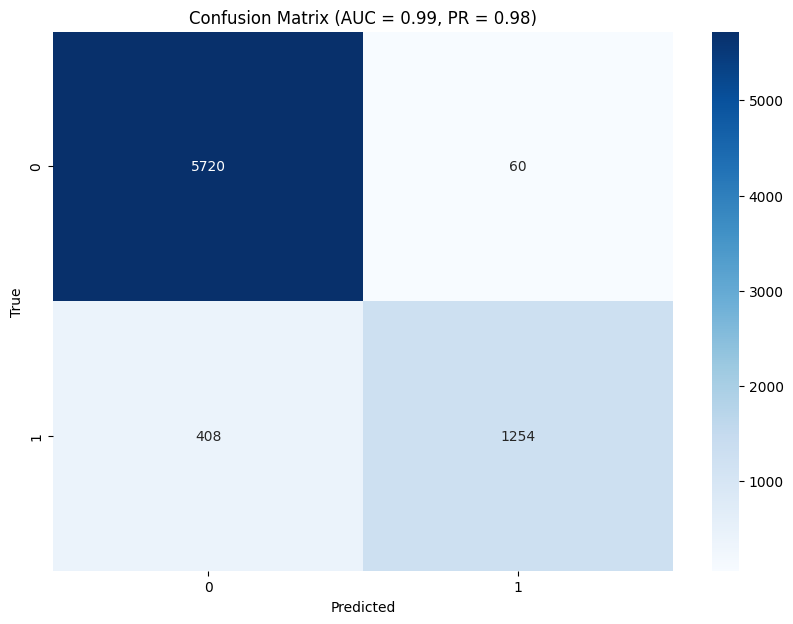

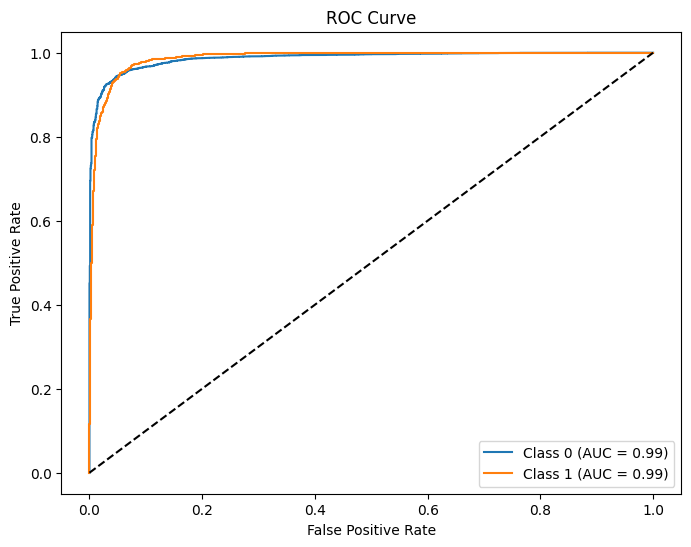

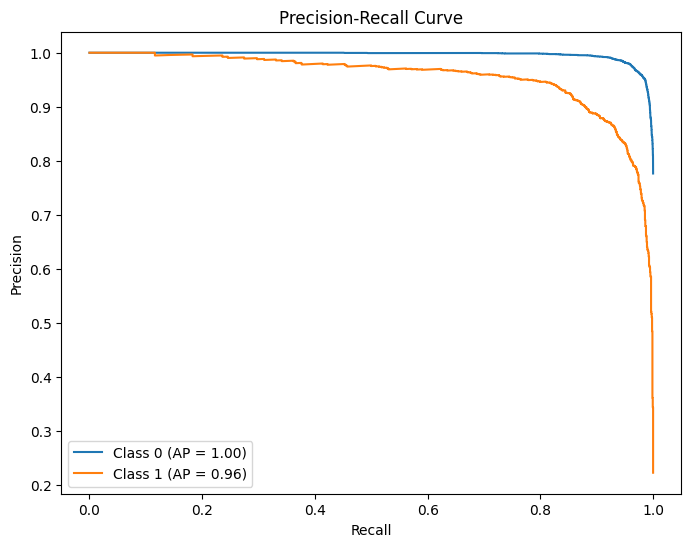

In [17]:
plot_confusion_matrix(train_predictor, train_labels, model)

80/80 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.8648 - loss: 0.9480
Evaluation Loss: 0.9202278852462769
Evaluation Accuracy: 0.8764659762382507
80/80 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step


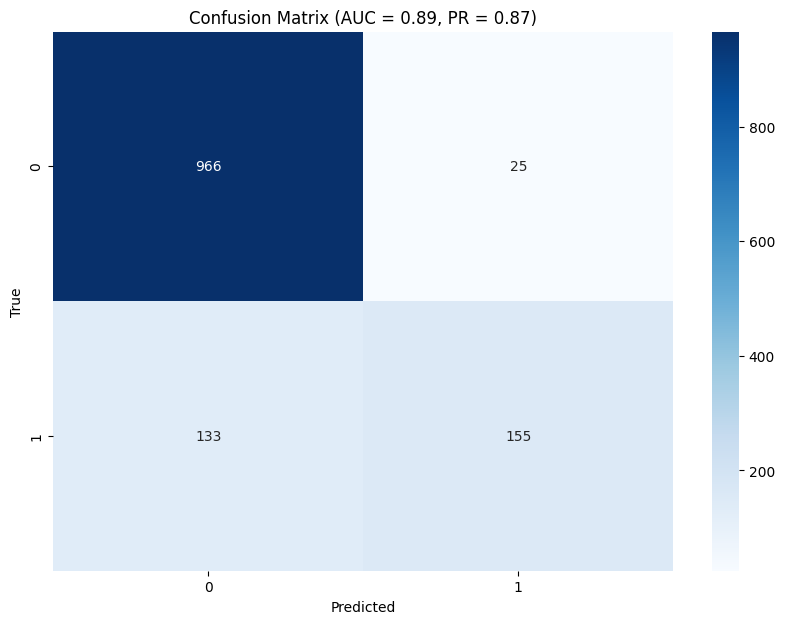

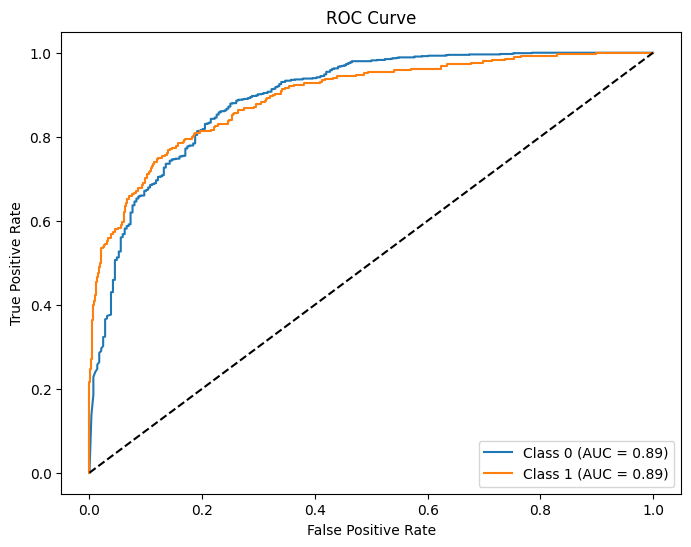

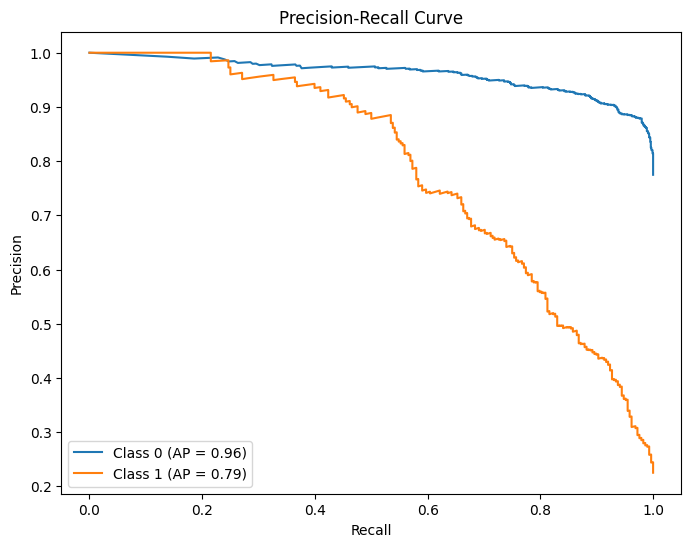

In [18]:
plot_confusion_matrix(val_predictor, val_labels, model)

80/80 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.8586 - loss: 0.9590
Evaluation Loss: 0.9462476968765259
Evaluation Accuracy: 0.8596078157424927
80/80 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step


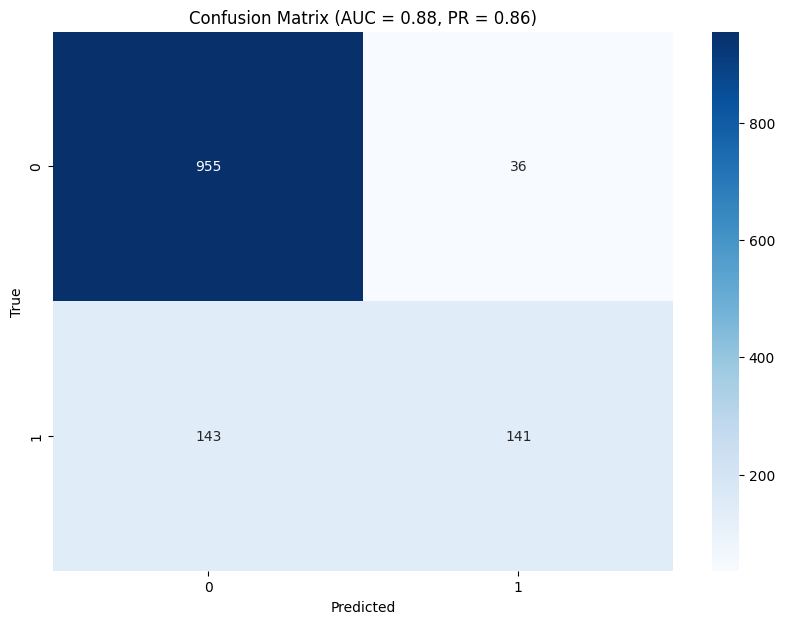

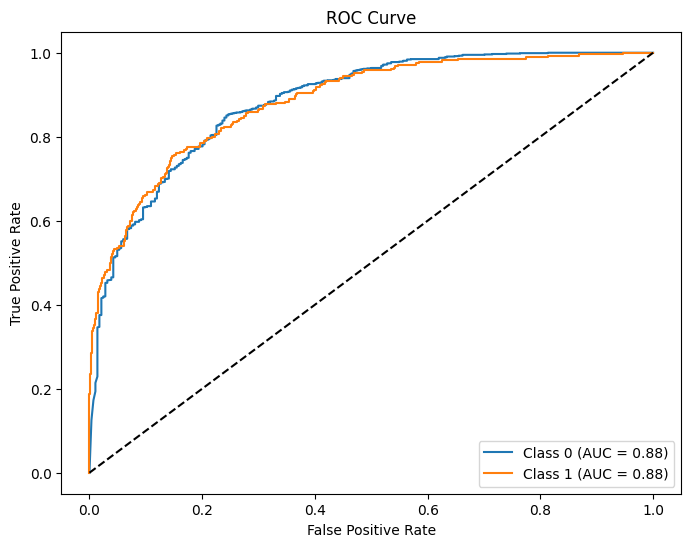

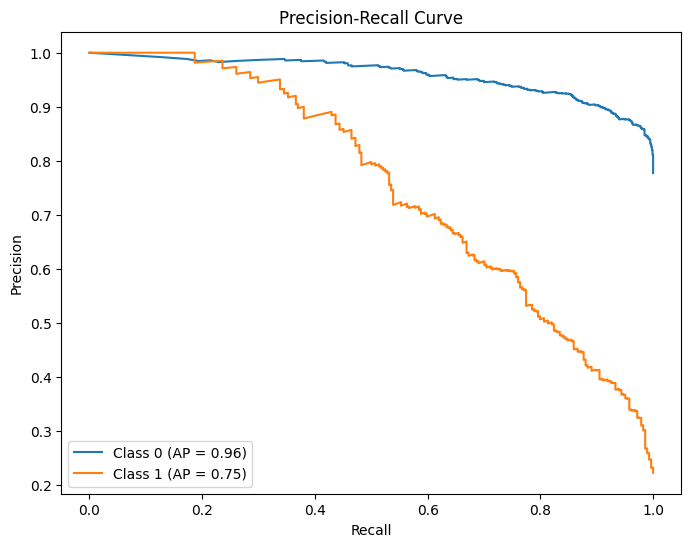

In [19]:
plot_confusion_matrix(test_predictor, test_labels, model)